In [1]:
import os

import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
df = df.sample(n=15000)
print(df.shape)
df.head()

(15000, 15)


,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
3719372,4,26,432,14223,83.01,11890.0,11.0,115.70,2001.11,133.0,131.0,474.0,340.0,2015,6
11606,8,1,1204,4548,84.97,118000.0,19.0,113.47,2009.12,476.0,153.0,4591.0,3438.0,2016,9
2171243,1,142,1268,13064,84.34,24900.0,15.0,102.48,2000.11,532.0,532.0,976.0,803.0,2011,11
13013,8,1,1495,14828,84.83,85000.0,6.0,104.87,1994.02,930.0,464.0,3312.0,2679.0,2016,7
5180436,10,46,836,6090,59.92,19400.0,25.0,79.34,1998.08,608.0,249.0,1070.0,808.0,2018,4


In [5]:
y = df['price']
del df['price']

In [6]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [7]:
lightgbm = lgb.LGBMRegressor(random_state=0)

In [8]:
kfold = KFold(n_splits=5, random_state=0).get_n_splits(x_train.values)
cross_val_score(lightgbm, x_train.values, y_train)

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.98717051, 0.95481825, 0.99150883])

In [9]:
lightgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
modelPred = lightgbm.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

2537.97172591042

In [11]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 9900.000, 예상가격: 9838.695
실제가격: 18900.000, 예상가격: 19367.009
실제가격: 26000.000, 예상가격: 26622.357
실제가격: 32500.000, 예상가격: 32591.413
실제가격: 20000.000, 예상가격: 19797.847
실제가격: 16700.000, 예상가격: 16560.229
실제가격: 25900.000, 예상가격: 25777.033
실제가격: 21000.000, 예상가격: 21269.600
실제가격: 26000.000, 예상가격: 25227.120
실제가격: 30800.000, 예상가격: 31024.811


In [12]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [14]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [15]:
history = model.fit(x_train, y_train, validation_split=0.4, epochs=100, batch_size=1000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 6300 samples, validate on 4200 samples
Epoch 1/100
6300/6300 [==============================] - 2s 317us/step - loss: 1038214113.5238 - acc: 0.0000e+00 - val_loss: 902692358.0952 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 902692358.09524, saving model to ./model/01-902692358.0952.hdf5
Epoch 2/100
6300/6300 [==============================] - 0s 9us/step - loss: 980145593.9048 - acc: 0.0000e+00 - val_loss: 839868748.1905 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 902692358.09524 to 839868748.19048, saving model to ./model/02-839868748.1905.hdf5
Epoch 3/100
6300/6300 [==============================] - 0s 9us/step - loss: 903001177.3968 - acc: 1.5873e-04 - val_loss: 735200408.3810 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 839868748.19048 to 735200408.38095, saving model to ./model/03-735200408.3810.hdf5
Epoch 4/100
6300/6300 [==============================] - 0s 10us/step - loss

6300/6300 [==============================] - 0s 5us/step - loss: 113294377.9048 - acc: 0.0000e+00 - val_loss: 98127232.0000 - val_acc: 2.3810e-04

Epoch 00029: val_loss improved from 98654412.19048 to 98127232.00000, saving model to ./model/29-98127232.0000.hdf5
Epoch 30/100
6300/6300 [==============================] - 0s 7us/step - loss: 112424122.9206 - acc: 1.5873e-04 - val_loss: 98138068.1905 - val_acc: 0.0000e+00

Epoch 00030: val_loss did not improve from 98127232.00000
Epoch 31/100
6300/6300 [==============================] - 0s 8us/step - loss: 111419866.0317 - acc: 1.5873e-04 - val_loss: 97611442.6667 - val_acc: 0.0000e+00

Epoch 00031: val_loss improved from 98127232.00000 to 97611442.66667, saving model to ./model/31-97611442.6667.hdf5
Epoch 32/100
6300/6300 [==============================] - 0s 10us/step - loss: 110505772.8254 - acc: 0.0000e+00 - val_loss: 97091023.2381 - val_acc: 0.0000e+00

Epoch 00032: val_loss improved from 97611442.66667 to 97091023.23810, saving model


Epoch 00059: val_loss improved from 79811141.52381 to 79286245.90476, saving model to ./model/59-79286245.9048.hdf5
Epoch 60/100
6300/6300 [==============================] - 0s 6us/step - loss: 89239899.1746 - acc: 0.0000e+00 - val_loss: 78764257.9048 - val_acc: 2.3810e-04

Epoch 00060: val_loss improved from 79286245.90476 to 78764257.90476, saving model to ./model/60-78764257.9048.hdf5
Epoch 61/100
6300/6300 [==============================] - 0s 7us/step - loss: 88434062.4762 - acc: 0.0000e+00 - val_loss: 77961355.6190 - val_acc: 2.3810e-04

Epoch 00061: val_loss improved from 78764257.90476 to 77961355.61905, saving model to ./model/61-77961355.6190.hdf5
Epoch 62/100
6300/6300 [==============================] - 0s 9us/step - loss: 87632068.3175 - acc: 0.0000e+00 - val_loss: 77438338.8571 - val_acc: 0.0000e+00

Epoch 00062: val_loss improved from 77961355.61905 to 77438338.85714, saving model to ./model/62-77438338.8571.hdf5
Epoch 63/100
6300/6300 [==============================] - 

6300/6300 [==============================] - 0s 7us/step - loss: 61974945.6508 - acc: 3.1746e-04 - val_loss: 54780963.4286 - val_acc: 4.7619e-04

Epoch 00089: val_loss improved from 54902182.47619 to 54780963.42857, saving model to ./model/89-54780963.4286.hdf5
Epoch 90/100
6300/6300 [==============================] - 0s 8us/step - loss: 61251987.8730 - acc: 3.1746e-04 - val_loss: 53193030.8571 - val_acc: 0.0000e+00

Epoch 00090: val_loss improved from 54780963.42857 to 53193030.85714, saving model to ./model/90-53193030.8571.hdf5
Epoch 91/100
6300/6300 [==============================] - 0s 10us/step - loss: 59623671.3651 - acc: 0.0000e+00 - val_loss: 52138919.0476 - val_acc: 2.3810e-04

Epoch 00091: val_loss improved from 53193030.85714 to 52138919.04762, saving model to ./model/91-52138919.0476.hdf5
Epoch 92/100
6300/6300 [==============================] - 0s 9us/step - loss: 58717936.4762 - acc: 0.0000e+00 - val_loss: 51548475.2381 - val_acc: 0.0000e+00

Epoch 00092: val_loss improv

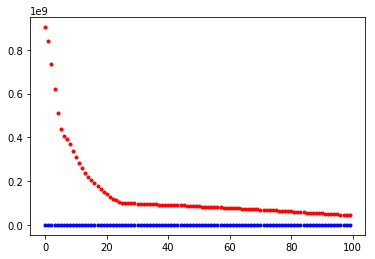

In [16]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [17]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

6863.400725641831

In [18]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 9900.000, 예상가격: 9644.774
실제가격: 18900.000, 예상가격: 20790.074
실제가격: 26000.000, 예상가격: 25423.281
실제가격: 32500.000, 예상가격: 29868.730
실제가격: 20000.000, 예상가격: 20867.244
실제가격: 16700.000, 예상가격: 18800.734
실제가격: 25900.000, 예상가격: 34361.586
실제가격: 21000.000, 예상가격: 24863.725
실제가격: 26000.000, 예상가격: 27089.570
실제가격: 30800.000, 예상가격: 38010.172


In [24]:
model = load_model('./model/99-44862888.9524.hdf5')

In [25]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

6872.4473990680235

In [26]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 9900.000, 예상가격: 9002.848
실제가격: 18900.000, 예상가격: 20318.992
실제가격: 26000.000, 예상가격: 24502.170
실제가격: 32500.000, 예상가격: 28690.734
실제가격: 20000.000, 예상가격: 20094.771
실제가격: 16700.000, 예상가격: 17975.434
실제가격: 25900.000, 예상가격: 33210.988
실제가격: 21000.000, 예상가격: 23728.490
실제가격: 26000.000, 예상가격: 25838.988
실제가격: 30800.000, 예상가격: 36891.695
